In [6]:
import openai
# MODEL = 'gpt-4o-2024-08-06'
MODEL = 'gpt-4o-mini'
from api_keys import OPEN_AI_API_KEYS
key = OPEN_AI_API_KEYS[0]
client = openai.OpenAI(api_key=key)
openai.api_key = key

import numpy as np
import pandas as pd
import csv

In [7]:
def prepare_messages(prompts):
	messages = []
	for prompt in prompts:
		line = {"role": "user", "content": prompt}
		messages.append(line)
	return messages

def get_model_output_initial_sentences(prompts, client): 
    # Cycle through clients to avoid rate limiting
	completion = client.chat.completions.create(
		model = MODEL,
		messages = prepare_messages(prompts),
		temperature = 0
	)
	output = completion.choices[0].message.content
	return output

In [8]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4o-mini",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

In [18]:
prompts = [
    "Please act as an impartial judge and evaluate the quality of the following responses provided by two ",
    "companies to the following questions. The companies may answer both questions or just one.",
    "Question 1: Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain target coverage and identify any exclusions ",
    "Question 2: Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain target coverage and identify any exclusions ",
    "Your evaluation should be primarily based on the tangible action that has already been taken, ",
    "and can also consider planned actions for the future. Your evaluation should also consider factors ",
    "such as the specificity, clarity, completeness, and depth of their responses.",
    "Do not allow the length of the responses to influence your evaluation. ",
    "Do not allow a missing response to influence your decision, but simply ignore it and focus on the other response. ",
    "Do not fall for greenwashing tactics.",
    # "Please strictly keep your explanation under 40 words.",

    "Do not allow the order of the responses to influence your decision. ",
    "Please decide which company gave a better response, based on the considerations above. ",

    # "Before giving your answer, please provide a short explanation of 40 or fewer words discussing the factors that contributed to your decision. ",
 
    # "After giving your explanation, ",
    # or 
    "Please do not provide an explanation. ",

    # "Output your final answer by strictly following this format: A if company A’s response is better, and B if company B’s response is better. "
    "Output your final answer by strictly following this format: Better Response: A if company A’s response is better, and Better Response: B if company B’s response is better. "

    "[The Start of Company A’s Question 1 Response] {answer1a} [The End of Company A’s Response]",
    "[The Start of Company A’s Question 2 Response] {answer1b} [The End of Company A’s Response]",
    "[The Start of Company B’s Question 1 Response] {answer2a} [The End of Company B’s Response]",
    "[The Start of Company B’s Question 2 Response] {answer2b} [The End of Company B’s Response]",
    
]

In [10]:
def get_log_prob(answer1a, answer1b, answer2a, answer2b, company_1, company_2):
    try:
        formatted_prompt = "".join(prompts).format(
            answer1a=answer1a, 
            answer1b=answer1b, 
            answer2a=answer2a, 
            answer2b=answer2b
        )
   
        API_RESPONSE = get_completion(
            [{"role": "user", "content": formatted_prompt.format(answer1a=answer1a, answer1b=answer1b, answer2a=answer2a, answer2b=answer2b)}],
            model="gpt-4o-mini",
            logprobs=True,
            top_logprobs=2,
        )

        generated_answer = API_RESPONSE.choices[0].message.content
        # print(f"Generated answer: {generated_answer}")
        top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[-1].top_logprobs


        token_probabilities = []
        for i, logprob in enumerate(top_two_logprobs, start=1):

            token = logprob.token
            probability = np.round(np.exp(logprob.logprob)*100,2)
            token_probabilities.append((token, probability))
            
        return generated_answer, token_probabilities
    except KeyError as e:
        print(f"KeyError: {e}")
        print("Variables: answer1a:", answer1a, "answer1b:", answer1b, "answer2a:", answer2a, "answer2b:", answer2b)
        return [],[]
    except Exception as e:
        print(f"An error occurred: {e}")
        return [],[]

In [11]:
# variables for each years' questions
a_2019 = "C4.1a_C12_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain"
b_2019 = "C4.1b_C13_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain"
a_2020 = "C4.1a_C15_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain (including target coverage)"
b_2020 = "C4.1b_C18_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain (including target coverage)"
a_2021 = "C4.1a_C16_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain (including target coverage)"
b_2021 = "C4.1b_C19_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain (including target coverage)"
a_2022 = "C4.1a_C27_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain target coverage and identify any exclusions"
b_2022 = "C4.1b_C30_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain target coverage and identify any exclusions"

In [82]:
import pandas as pd
import csv

# Read the main dataset and the list of 25 companies
input_file = 'merged_files/2022_merged_dataset.csv'
# companies_to_look_at = "malicious_greenwashing_output/testing_greenwashing_prompt_v3/80_new_responses.csv"

# companies_to_look_at = "malicious_greenwashing_output/strict/101_new_responses.csv"
companies_to_look_at = "malicious_greenwashing_output/original/101_new_responses.csv"
output_file = "malicious_greenwashing_output/original/pairwise_no_explanation.csv"
# 24 companies
comparison_set = [
    "Pandora A/S", "thyssenkrupp AG", "J Sainsbury Plc", "AMG Advanced Metallurgical Group NV", 
    "Sonaca", "Havas", "Norwegian Property ASA", "Phoenix Group Holdings", 
    "SGS Société Générale de Surveillance SA", "TDC NET A/S", "DUCRON CONSTRUCTION", 
    "Vistry Group plc", "LAMBERT SMITH HAMPTON", 
    "Nouvelle Societe Mineral Products Internation", "Recordati SpA", "SKF", 
    "Amadeus IT Group, S.A.", "Vitesco Technologies", "SSAB", 
    "Coloplast A/S", "Severn Trent", "Ernst & Young Global Ltd", 
    "Softcat", "WHISTL UK LTD"
]

# Load datasets
df = pd.read_csv(input_file)
a_df = pd.read_csv(companies_to_look_at)

# Extract columns
company_name_list = df.loc[:, "Organization"]
industry_list = df.loc[:, 'Primary industry']
a_response_list = df.loc[:, a_2022] 
b_response_list = df.loc[:, b_2022]  

# Extract the companies to compare (from the list of 25 companies)
companies_to_look_at_list = a_df["Company"].tolist()

companies_response_a = a_df["New Response A"]
companies_response_b = a_df["New Response B"]


fields = ["Company A", "Company B", "Decision", "Token 1", "LogProb 1", "Token 2", "LogProb 2"]

# Write output to CSV
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fields, quoting=csv.QUOTE_ALL)
    writer.writeheader()

    # Loop through the 147 companies
    for index, companyA in enumerate(companies_to_look_at_list):
    # start_index = 7
    # for index, companyA in enumerate(companies_to_look_at_list[start_index:10], start=start_index):

        # Check if the current company exists in the dataset
        if companyA in company_name_list.values:
            # row = df[df["Organization"] == companyA].iloc[0]  # Get the row for the current company
            # industry = row["Primary industry"]
            # print(companyA)
            response1a = a_df.loc[a_df["Company"] == companyA, "New Response A"].values[0]
            response1b = a_df.loc[a_df["Company"] == companyA, "New Response B"].values[0]
            # company_index = companies_response_a.index.get_loc(companyA)
            
            # response1a = companies_response_a[company_index]
            # response1b = companies_response_a[company_index]

            # print(f"Comparing {companyA} in industry {industry}")
        
            # Compare against the fixed list of 24 companies
            filtered_df = df[df["Organization"].isin(comparison_set)]
            a_random_response_list = filtered_df.loc[:, a_2022]
            b_random_response_list = filtered_df.loc[:, b_2022]
            random_company_name_list = filtered_df.loc[:, "Organization"]

            # Loop through the 24 fixed companies
            for random_list_index in range(len(filtered_df)):
                response2a = a_random_response_list.iloc[random_list_index]
                response2b = b_random_response_list.iloc[random_list_index]
                companyB = random_company_name_list.iloc[random_list_index]

                print(f"Comparing {companyA} with {companyB}")

                # Call the function to get log probabilities and tokens
                answer1, list_log_probs = get_log_prob(response1a, response1b, response2a, response2b, companyA, companyB)
                # print(f"Answer 1: {answer1}")
                if list_log_probs:
                    # Write data to CSV
                    line = {
                        "Company A": companyA, 
                        "Company B": companyB,
                        "Decision": answer1, 
                        "Token 1": list_log_probs[0][0], 
                        "LogProb 1": list_log_probs[0][1], 
                        "Token 2": list_log_probs[1][0],
                        "LogProb 2": list_log_probs[1][1]
                    }
                    writer.writerow(line)
                else:
                    print(f"Insufficient log probabilities for comparison between {companyA} and {companyB}.")

print(f"LogProbs have been written to {output_file}")

ADM Group
Comparing ADM Group with AMG Advanced Metallurgical Group NV
Comparing ADM Group with Amadeus IT Group, S.A.
Comparing ADM Group with Coloplast A/S
Comparing ADM Group with DUCRON CONSTRUCTION
Comparing ADM Group with Ernst & Young Global Ltd
Comparing ADM Group with Havas
Comparing ADM Group with J Sainsbury Plc
Comparing ADM Group with LAMBERT SMITH HAMPTON
Comparing ADM Group with Norwegian Property ASA
Comparing ADM Group with Nouvelle Societe Mineral Products Internation
Comparing ADM Group with Pandora A/S
Comparing ADM Group with Phoenix Group Holdings
Comparing ADM Group with Recordati SpA
Comparing ADM Group with SGS Société Générale de Surveillance SA
Comparing ADM Group with SKF
Comparing ADM Group with SSAB
Comparing ADM Group with Severn Trent
Comparing ADM Group with Softcat
Comparing ADM Group with Sonaca
Comparing ADM Group with TDC NET A/S
Comparing ADM Group with Vistry Group plc
Comparing ADM Group with Vitesco Technologies
Comparing ADM Group with WHISTL U

computing average log probs

In [83]:
import pandas as pd

# # File paths
# input_file = "malicious_greenwashing_output/pairwise_all_versions/without_explanation/original.csv"
# output_file = "malicious_greenwashing_output/pairwise_all_versions/without_explanation/averages_original.csv"

input_file = "malicious_greenwashing_output/original/pairwise_no_explanation.csv"
output_file = "malicious_greenwashing_output/original/averages_pairwise_no_explanation.csv"
# Read input CSV
df = pd.read_csv(input_file)

# Initialize tracking variables
log_prob_data = {}
current_company = None
total_score = 0.0
total_count = 0

# Iterate over each row
for index, row in df.iterrows():
    company_a = row['Company A']
    token_1 = row['Token 1'].strip()
    logprob_1 = row['LogProb 1']
    logprob_2 = row['LogProb 2']

    # Check for a new company
    if company_a != current_company:
        # Finalize the previous company's calculations
        if current_company is not None and total_count > 0:
            avg_log_prob = total_score / total_count
            log_prob_data[current_company] = avg_log_prob

        # Reset counters for the new company
        current_company = company_a
        total_score = 0.0
        total_count = 0

    # Add probabilities for both scenarios
    if token_1 == 'A':
        total_score += logprob_1
    else:  # Token 1 is 'B'
        total_score += logprob_2
    total_count += 1

# Finalize the last company's calculations
if current_company is not None and total_count > 0:
    avg_log_prob = total_score / total_count
    log_prob_data[current_company] = avg_log_prob

# Create a DataFrame from the results
log_prob_df = pd.DataFrame([
    {'Company': company, 'Average': avg_log_prob}
    for company, avg_log_prob in log_prob_data.items()
])

# Save to CSV
log_prob_df.to_csv(output_file, index=False)

print("Average log probabilities have been calculated and saved.")

Average log probabilities have been calculated and saved.


compute average score of entire file

In [86]:
def compute_column_average(file_path, column_name):
    try:
        with open(file_path, 'r') as file:
            csv_reader = csv.DictReader(file)
            
            # Check if the column exists
            if column_name not in csv_reader.fieldnames:
                print(f"Error: Column '{column_name}' not found in the file.")
                return None
            
            values = []
            for row in csv_reader:
                try:
                    # Convert the column value to float and add it to the list
                    values.append(float(row[column_name]))
                except ValueError:
                    print(f"Warning: Non-numeric value found in column '{column_name}', skipping it.")
            
            if not values:
                print(f"Error: No numeric values found in column '{column_name}'.")
                return None
            
            # Calculate and return the average
            return sum(values) / len(values)
    except FileNotFoundError:
        print(f"Error: The file {file_path} does not exist.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return None

# Example usage
file_path = "malicious_greenwashing_output/original/averages_pairwise_no_explanation.csv"
# file_path = "malicious_greenwashing_output_old/pairwise_all_versions/without_explanation/averages_original.csv"
column_name = "Average"
average = compute_column_average(file_path, column_name)
if average is not None:
    print(f"The average for column '{column_name}' is: {average}")


The average for column 'Average' is: 58.374801980198036


In [84]:
# method that calculates the total variation distance between two histograms
def calculate_tvd(hist1, hist2):
    # Normalize histograms to sum to 1 (convert to probability distributions)
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    
    # Calculate the total variation distance
    tvd = 0.5 * np.sum(np.abs(hist1 - hist2))
    return tvd

KS Statistic: 0.19052530253025302
TVD =  0.3517601760176018
EMD =  11.413641364136407


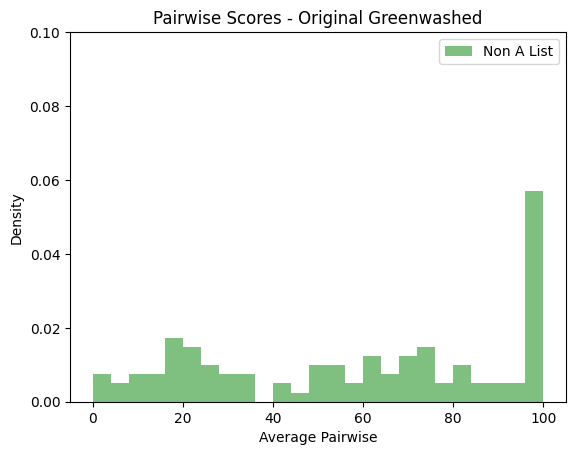

In [85]:
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


# # Load data
# file_a = "pairwise_testing_new_prompt/without_explanation/Averages_147_A_List.csv"
# file_b = "malicious_greenwashing_output_old/pairwise_all_versions/without_explanation/averages_original.csv"

file_a = "pairwise_testing_new_prompt/without_explanation/Averages_147_A_List.csv"
file_b = "malicious_greenwashing_output/original/averages_pairwise_no_explanation.csv"
df_average_a_list_companies = pd.read_csv(file_a)
df_average_companies = pd.read_csv(file_b)

# Bins and bin centers
bins = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100]
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Histograms (normalized)
hist1, _ = np.histogram(df_average_a_list_companies["Average"], bins=bins, density=True)
hist2, _ = np.histogram(df_average_companies["Average"], bins=bins, density=True)

# KS Statistic
ks_statistic, p_value = stats.ks_2samp(df_average_a_list_companies["Average"], df_average_companies["Average"])
print(f"KS Statistic: {ks_statistic}")
# print(f"P-value: {p_value}")

# # TVD (Normalized)
# tvd = 0.5 * np.sum(np.abs(hist1 - hist2))
# print("TVD = ", tvd)

tvd = calculate_tvd(hist1, hist2)
print("TVD = ", tvd)

# EMD (Normalized)
emd = wasserstein_distance(bin_centers, bin_centers, u_weights=hist1, v_weights=hist2)
print("EMD = ", emd)

# Plotting
plt.ylim(0, 0.1)  # Adjust the max y-axis value to 10
# plt.hist(df_average_a_list_companies["Average"], bins=bins, alpha=0.5, label='A-list Companies', color='blue', density=True)
plt.hist(df_average_companies["Average"], bins=bins, alpha=0.5, label='Non A List', color='green', density=True)
plt.xlabel('Average Pairwise')
plt.ylabel('Density')
# hist_title = "Pairwise - A List vs Original Non Greenwashed"
hist_title = "Pairwise Scores - Original Greenwashed"
plt.title(hist_title)
plt.legend(loc='upper right')

# Display plot
plt.show()
